# imports

In [1]:
# all imports

# buffer
from collections import defaultdict
import random
from abc import ABC, abstractmethod
from typing import (
    Any,
    Dict,
    Generic,
    Optional,
    List,
    TYPE_CHECKING,
    Set,
    TypeVar,
)

from avalanche.benchmarks.utils import (
    classification_subset,
    AvalancheDataset,
)
from avalanche.models import FeatureExtractorBackbone
# from ..benchmarks.utils.utils import concat_datasets
from avalanche.benchmarks.utils import concat_datasets
from avalanche.training.storage_policy import ReservoirSamplingBuffer, BalancedExemplarsBuffer, ClassBalancedBuffer

from avalanche.training.storage_policy import ParametricBuffer, RandomExemplarsSelectionStrategy, ExemplarsBuffer, ExperienceBalancedBuffer
from avalanche.benchmarks.utils.data_loader import ReplayDataLoader
from avalanche.training.plugins import SupervisedPlugin
from typing import Optional, TYPE_CHECKING

from avalanche.benchmarks.utils import concat_classification_datasets
from avalanche.training.plugins.strategy_plugin import SupervisedPlugin

if TYPE_CHECKING:
    from avalanche.training.templates import SupervisedTemplate, BaseSGDTemplate

# dataset
from avalanche.benchmarks import SplitMNIST, SplitCIFAR100
from avalanche.benchmarks.classic import SplitCIFAR100
from avalanche.benchmarks.classic import SplitCIFAR10
from avalanche.benchmarks.utils.data_loader import GroupBalancedDataLoader, ReplayDataLoader
from avalanche.benchmarks.generators import nc_benchmark, ni_benchmark
from avalanche.benchmarks.generators import filelist_benchmark, dataset_benchmark, \
                                            tensors_benchmark, paths_benchmark

from avalanche.logging import InteractiveLogger, TensorboardLogger, \
    WandBLogger, TextLogger, TensorboardLogger

from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import forgetting_metrics, accuracy_metrics, loss_metrics

from avalanche.training.plugins.checkpoint import CheckpointPlugin, \
    FileSystemCheckpointStorage
from avalanche.training.determinism.rng_manager import RNGManager
from avalanche.training import Naive, CWRStar, Replay, GDumb, \
    Cumulative, LwF, GEM, AGEM, EWC, AR1
from avalanche.models import SimpleMLP
from avalanche.training import Naive, CWRStar, Replay, GDumb, \
    Cumulative, LwF, GEM, AGEM, EWC, AR1
from avalanche.models import SimpleMLP
from avalanche.training.plugins import ReplayPlugin
from types import SimpleNamespace
from avalanche.training.storage_policy import ParametricBuffer, RandomExemplarsSelectionStrategy

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import inf

In [3]:
# all imports

import torch
import os
from torch import cat, Tensor
from torch.nn import Module
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset, ConcatDataset, TensorDataset
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torchvision import datasets, transforms
import torch.optim.lr_scheduler # ?
from torchvision.transforms import Compose, ToTensor, Normalize, RandomCrop, CenterCrop, RandomHorizontalFlip, Resize
from torchvision.transforms.functional import center_crop
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.utils import save_image
from torchvision.transforms.functional import pil_to_tensor


In [4]:
torch.cuda.set_device(6)
if torch.cuda.is_available():
    current_gpu = torch.cuda.current_device()
    print(f"Current default GPU index: {current_gpu}")
    print(f"Current default GPU name: {torch.cuda.get_device_name(current_gpu)}")
else:
    print("No GPUs available.")

Current default GPU index: 6
Current default GPU name: NVIDIA A40


In [5]:
# import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import os

stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

transform = transform_train = Compose([
    # Resize(224),
    # Resize(384),
    # RandomHorizontalFlip(),
    ToTensor(),
    # Normalize(*stats,inplace=True)
])

# Load the CIFAR-100 training set
trainset = torchvision.datasets.CIFAR100(root='data', train=True,
                                         download=True, transform=transform)

name_list = trainset.classes

Files already downloaded and verified


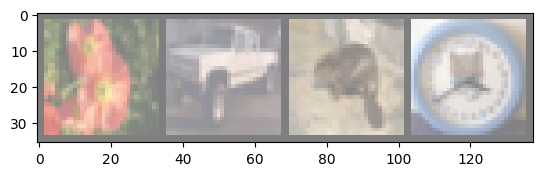

poppy pickup_truck beaver clock


In [6]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt


trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

# Function to show images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize if Normalize was used in transform
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join('%5s' % trainset.classes[labels[j]] for j in range(4)))


In [7]:

def tensor_to_pil(image_tensor):
    return transforms.ToPILImage()(image_tensor).convert("RGB")

In [8]:
import os
import torch
import torchvision
from torchvision.transforms import Compose, Resize, RandomHorizontalFlip, ToTensor
from torchvision.utils import save_image


def save_cifar100_random_replay(dataset, num_images_per_class, save_dir):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    torch.manual_seed(41)

    saved_counts = {label: 0 for label in range(100)}  # Initialize saved image count for each class
    
    transform_to_tensor = transforms.ToTensor()
    
    indices = torch.randperm(len(dataset)).tolist()
    for idx in indices:
        image, label = dataset[idx]
        image_tensor = transform_to_tensor(image)

        # Skip saving if this class already has the desired number of images saved
        if saved_counts[label] >= num_images_per_class:
            continue

        class_name = dataset.classes[label]
        image_path = os.path.join(save_dir, f'{class_name}_{saved_counts[label]}.png')
        save_image(image_tensor, image_path)
        saved_counts[label] += 1

        # Check if we have finished saving max_images for all classes
        class_file_path = os.path.join(save_dir, f"class{label}.txt")
        with open(class_file_path, "a") as file:
            file.write(f"{image_path} {label}\n")

        # Check if we have finished saving the specified number of images for all classes
        if all(count >= num_images_per_class for count in saved_counts.values()):
            break

    print(f"Saved {num_images_per_class} images per class from the CIFAR-100 training dataset.")

In [9]:
# save_cifar100_random_replay(trainset, 50, 'saved_data/cifar0411_1')

In [10]:
integer_to_name = {i: name for i, name in enumerate(name_list)}


In [11]:
for id in integer_to_name:
    print(id, integer_to_name[id])
    break

0 apple


# Data transform

In [12]:
# !pip install pytorch_pretrained_vit


import torch
import matplotlib.pyplot as plt
import numpy as np
# ?

from avalanche.benchmarks.classic import SplitCIFAR100
from avalanche.benchmarks.classic import SplitCIFAR10

from avalanche.benchmarks.generators import nc_benchmark, ni_benchmark

from avalanche.benchmarks.generators import filelist_benchmark, dataset_benchmark, \
                                            tensors_benchmark, paths_benchmark



In [13]:
from torchvision import transforms
from torchvision.transforms import Compose, ToTensor, Normalize, RandomCrop, RandomHorizontalFlip, Resize
import os
# stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
transform_train = Compose([
    Resize(224),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize(*stats,inplace=True)
])

transform_test = Compose([
    Resize(224),
    ToTensor(),
    Normalize(*stats,inplace=True)
])


In [14]:
from avalanche.logging import InteractiveLogger, TextLogger, TensorboardLogger
from avalanche.logging import InteractiveLogger, TensorboardLogger, \
    WandBLogger, TextLogger
# log to Tensorboard
tb_logger = TensorboardLogger()

# log to text file
text_logger = TextLogger(open('logs/log_turbo_llava_i2i_step30.txt', 'a'))

# print to stdout
interactive_logger = InteractiveLogger()

In [15]:
# evaluation
from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import forgetting_metrics, accuracy_metrics, loss_metrics, class_accuracy_metrics

# The evaluation plugin manages the metrics computation.
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=False, epoch=True, experience=True, stream=True),
    loss_metrics(minibatch=False, epoch=True, experience=True, stream=True),
    class_accuracy_metrics(minibatch=False, epoch=False, epoch_running=False, experience=False, stream=True),
    # forgetting_metrics(experience=True, stream=True),
    loggers=[interactive_logger, text_logger, tb_logger])

In [16]:
from avalanche.training.plugins.checkpoint import CheckpointPlugin, \
    FileSystemCheckpointStorage
from avalanche.training.determinism.rng_manager import RNGManager


In [17]:
RNGManager.set_random_seeds(1234)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

checkpoint_plugin = CheckpointPlugin(
    FileSystemCheckpointStorage(
        directory='./checkpoints/task_cifar',
    ),
    map_location=device
)

# Load checkpoint (if exists in the given storage)
# If it does not exist, strategy will be None and initial_exp will be 0
strategy, initial_exp = checkpoint_plugin.load_checkpoint_if_exists()

cuda


In [18]:
import os
import random

def combine_files_with_numbers(folder, file_initial, numbers, output_folder):
    """use to get the data with label in the training experience"""
    combined_content = ""  # Initialize an empty string to store combined content
    # Compile a set of filenames to look for, based on the list of numbers
    filenames_to_look_for = {file_initial + f"{number}.txt" for number in numbers}

    # Iterate over each file in the specified folder
    for file in os.listdir(folder):
        # Check if the file name matches exactly any in our set of filenames to look for
        if file in filenames_to_look_for:
            # Open and read the file, then add its content to the combined_content string
            with open(os.path.join(folder, file), 'r') as f:
                combined_content += f.read()  # Add a newline character after each file's content for better separation

    joined_string = '_'.join(str(integer) for integer in numbers)

    os.makedirs(output_folder, exist_ok=True)

    output_file_path = output_folder +file_initial+ 'combined' + '_' + joined_string + '.txt'
    print(output_file_path)
    with open(output_file_path, 'w') as f:
        f.write(combined_content)

def shuffle_text_file_lines(file_path):
    """
    Shuffles the lines in a text file.

    Parameters:
    - file_path: Path to the text file to shuffle.
    """
    # Read the lines from the file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Shuffle the lines
    random.shuffle(lines)

    # Write the shuffled lines back to the file
    with open(file_path, 'w') as file:
        file.writelines(lines)

# customize replay plugin

In [19]:
class CustomReplay_SD(SupervisedPlugin):
    def __init__(
        self,
        # sd_data,
        mem_size: int = 200,
        batch_size: Optional[int] = None,
        batch_size_mem: Optional[int] = None,
        task_balanced_dataloader: bool = False,
        storage_policy: Optional["ExemplarsBuffer"] = None,
        image_folder = None
        # The policy that controls how to add new exemplars in memory
                        #
    ):
        super().__init__()
        # self.sd_data = sd_data
        self.mem_size = mem_size
        self.batch_size = batch_size
        self.batch_size_mem = batch_size_mem
        self.task_balanced_dataloader = task_balanced_dataloader

        self.storage_policy = storage_policy
        self.image_folder = image_folder
        assert storage_policy.max_size == self.mem_size

        if storage_policy is not None:  # Use other storage policy
            self.storage_policy = storage_policy
            assert storage_policy.max_size == self.mem_size
        else:  # Default
            self.storage_policy = ExperienceBalancedBuffer(
                max_size=self.mem_size, adaptive_size=True
            )

    def before_training_exp(
        self,
        strategy: "SupervisedTemplate",
        num_workers: int = 0,
        shuffle: bool = True,
        drop_last: bool = False,
        **kwargs
    ):
        """
        Dataloader to build batches containing examples from both memories and
        the training dataset
        """
        if len(self.storage_policy.buffer) == 0:
            return

#         batch_size = self.batch_size
#         if batch_size is None:
#             batch_size = strategy.train_mb_size

        batch_size_mem = self.batch_size_mem
        if batch_size_mem is None:
            batch_size_mem = strategy.train_mb_size

        assert strategy.adapted_dataset is not None
        strategy.dataloader = ReplayDataLoader(
            strategy.adapted_dataset,
            self.storage_policy.buffer,
            batch_size=strategy.train_mb_size,
            num_workers=num_workers,
            shuffle=shuffle,
        )

    def after_training_exp(self, strategy: "SupervisedTemplate", **kwargs):
        """ We update the buffer after the experience.
            You can use a different callback to update the buffer in a different place
        """
        print("Buffer update.")
        buffer_size = len(self.storage_policy.buffer)
        print("buffer size: " + str(buffer_size))
        num_class = len(self.storage_policy.buffer_datasets)
        print("current class number in replay buffer: " + str(num_class))
        # self.storage_policy.update(strategy, **kwargs)

        # print(type(strategy.experience))

        current_experience = strategy.experience

        current_classes = current_experience.classes_in_this_experience
        print(current_classes)
        # create the combined txt file with current classes
        print("start to combine files...")
        combine_files_with_numbers(
            self.image_folder,
            'class',
            current_classes,
            self.image_folder + 'combined/')
        joined_string = '_'.join(str(integer) for integer in current_classes)
        combined_file_name = self.image_folder + 'combined/' + 'class' + 'combined' + '_' + joined_string + '.txt'

        cur_train_set = [combined_file_name]

        print("start generating sd data scenario...")
        sd_dataset_scenario =  filelist_benchmark(
                                None,
                                train_file_lists = cur_train_set, # train
                                test_file_lists = [], # test
                                task_labels = [0],
                                # complete_test_set_only=True,
                                train_transform=transform_train,
                            eval_transform=transform_train
                            )
        sd_data = SimpleNamespace(experience = sd_dataset_scenario.train_stream[0])
        # storage_p.update(strategy_state)

        print("start updating sd data into buffer")
        self.storage_policy.update(sd_data, **kwargs)


# experiment 20 tasks

In [20]:
# training
from avalanche.training import Naive, CWRStar, Replay, GDumb, \
    Cumulative, LwF, GEM, AGEM, EWC, AR1

# strategies
from avalanche.models import SimpleMLP
from torch.optim import SGD
from torch.nn import CrossEntropyLoss

In [21]:
from torchvision.models import resnet18, ResNet18_Weights
weights = ResNet18_Weights.DEFAULT
resnet_model = resnet18(weights=weights)

In [22]:
# training
from avalanche.training import Naive, CWRStar, Replay, GDumb, \
    Cumulative, LwF, GEM, AGEM, EWC, AR1

# strategies
from avalanche.models import SimpleMLP
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from avalanche.training.plugins import ReplayPlugin

from types import SimpleNamespace

In [23]:
benchmark = SplitCIFAR100(n_experiences=20,
                          train_transform=transform_train,
                          eval_transform = transform_test,
                          seed = 41
                          )

Files already downloaded and verified
Files already downloaded and verified


In [24]:
from avalanche.training.storage_policy import ParametricBuffer, RandomExemplarsSelectionStrategy
from avalanche.training.storage_policy import ParametricBuffer, RandomExemplarsSelectionStrategy
storage_p = ParametricBuffer(
    max_size=60000,
    groupby='class',
    selection_strategy=RandomExemplarsSelectionStrategy()
    # selection_strategy=RandomExemplarsSelectionStrategy()

)


print(f"Max buffer size: {storage_p.max_size}, current size: {len(storage_p.buffer)}")
for i in range(5):
    strategy_state = SimpleNamespace(experience=benchmark.train_stream[i])
    # print(len(benchmark.train_stream[i]))
    storage_p.update(strategy_state)
    print(f"Max buffer size: {storage_p.max_size}, current size: {len(storage_p.buffer)}")
    # print(f"class targets: {storage_p.buffer.targets}\n")

Max buffer size: 60000, current size: 0
Max buffer size: 60000, current size: 2500
Max buffer size: 60000, current size: 5000
Max buffer size: 60000, current size: 7500
Max buffer size: 60000, current size: 10000
Max buffer size: 60000, current size: 12500


In [25]:
storage_p = ParametricBuffer(
    max_size=60000,
    groupby='class',
    selection_strategy=RandomExemplarsSelectionStrategy()
    # selection_strategy=RandomExemplarsSelectionStrategy()

)


## data

In [26]:
# import zipfile
# import os

# def unzip_file(zip_path, extract_to):
#     # Ensure the target directory exists; if not, create it
#     if not os.path.exists(extract_to):
#         os.makedirs(extract_to)

#     # Open the ZIP file
#     with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#         # Extract all the contents into the specified directory
#         zip_ref.extractall(extract_to)
#         print(f"Files extracted to {extract_to}")


In [27]:
# # Example usage
# zip_file_path = 'saved_data/sd_v15_scale_8_seed41.zip'
# target_path = 'saved_data/sd_scale8_test'
# unzip_file(zip_file_path, target_path)

In [28]:
import os

def modify_paths_in_files(file_folder_path, new_path_to_write):
    """
    Modifies the file paths in all text files within a specified folder to a new directory.

    Args:
    folder_path (str): The path to the folder containing the text files.
    new_directory (str): The new directory path to prepend to the file names in the text files.
    """
    for filename in os.listdir(file_folder_path):
        file_path = os.path.join(file_folder_path, filename)
        if os.path.isfile(file_path) and filename.endswith('.txt'):
            with open(file_path, 'r') as file:
                lines = file.readlines()

            modified_lines = []
            for line in lines:
                parts = line.strip().split()
                if len(parts) == 2:
                    old_path, label = parts
                    # Extract the base file name from the original path
                    base_name = os.path.basename(old_path)
                    # Construct the new path
                    new_path = os.path.join(new_path_to_write, base_name)
                    # Append the modified line to the list
                    modified_lines.append(f"{new_path} {label}\n")

            # Write the modified lines back to the file
            
            with open(file_path, 'w') as file:
                file.writelines(modified_lines)
    print(f"Updated")



In [29]:
# # Example usage
# file_folder_path = 'saved_data/sd_scale8_test/cifar100_sd_v15_0314_scale_8_seed41'
# new_path_to_write = 'saved_data/sd_scale8_test/cifar100_sd_v15_0314_scale_8_seed41'  # Assuming you meant this is a directory and not just a suffix
# modify_paths_in_files(file_folder_path, new_path_to_write)


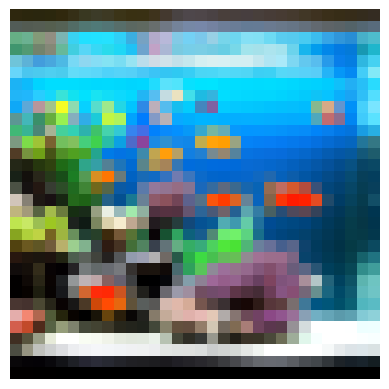

In [30]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_image_with_matplotlib(image_path):
    """
    Display an image using matplotlib.

    Args:
    image_path (str): The path to the image file.
    """
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()

# Example usage
image_path = 'saved_data/sd_scale8_test/cifar100_sd_v15_0314_scale_8_seed41/aquarium_fish7.png'
display_image_with_matplotlib(image_path)


## sd_turbo_llava replay

In [31]:
cl_strategy = Naive(
    resnet_model, torch.optim.SGD(resnet_model.parameters(), lr=0.01, momentum = 0.9),
    CrossEntropyLoss(), train_mb_size=32, train_epochs=50, eval_mb_size=16,
    # eval_every=500,
    device=device,
    evaluator=eval_plugin,
    plugins=[CustomReplay_SD(mem_size=60000, storage_policy = storage_p, 
                             image_folder= 'saved_data/sd_turbo_i2i_50all_step30')]
    )
# mem_size: int = 200,
        # batch_size: Optional[int] = None,
        # batch_size_mem: Optional[int] = None,
        # task_balanced_dataloader: bool = False,
        # storage_policy: Optional["ExemplarsBuffer"] = None,

In [32]:
# Training
print('Starting experiment...')
results = []
for experience in benchmark.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)

    # train returns a dictionary which contains all the metric values
    res = cl_strategy.train(experience)
    print('Training completed')

    print('Computing accuracy on the whole test set')
    # test also returns a dictionary which contains all the metric values
    results.append(cl_strategy.eval(benchmark.test_stream))

Starting experiment...
Start of experience:  0
Current Classes:  [0, 36, 5, 20, 54]
-- >> Start of training phase << --
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.31it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.2258
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.7240
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:07<00:00, 10.12it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.4093
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8668
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.72it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.1815
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9420
100%|██████████████████████████████████████████████████████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:07<00:00, 10.57it/s]
Epoch 30 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0064
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9980
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:07<00:00,  9.96it/s]
Epoch 31 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0540
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9860
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:07<00:00, 10.28it/s]
Epoch 32 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.1264
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9656
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:07<00:00, 10.33it/s]
Epoch 33 ended.
	Loss_Epoch/train_phase/train_stream/Tas

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 21.35it/s]
> Eval on experience 6 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp006 = 19.3330
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp006 = 0.0000
-- Starting eval on experience 7 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.04it/s]
> Eval on experience 7 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp007 = 19.6383
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp007 = 0.0000
-- Starting eval on experience 8 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 22.99it/s]
> Eval on experience 8 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp008 = 

	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/49 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/5 = 0.9600
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/50 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/51 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/52 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/53 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/54 = 0.9800
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/55 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/56 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/57 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/58 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/59 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/6 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/60 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/61 = 0.0000
	Top1_ClassAcc_Stream/eval_

	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.7385
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:31<00:00,  2.50it/s]
Epoch 17 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.6990
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.7836
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:31<00:00,  2.54it/s]
Epoch 18 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.6938
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.7916
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:30<00:00,  2.60it/s]
Epoch 19 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.6123
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8069
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:36<00:00,  2.14it/s

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:32<00:00,  2.46it/s]
Epoch 47 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0394
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9876
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:31<00:00,  2.54it/s]
Epoch 48 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0215
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9931
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:30<00:00,  2.60it/s]
Epoch 49 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0338
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9887
Buffer update.
buffer size: 250
current class number in replay buffer: 5
[13, 45, 83, 19, 22]
start to combine files...
saved_data/sd_turbo_i2i_50all_step30combined/classcombined_13_45_83_19_22.tx

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  6.97it/s]
> Eval on experience 18 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp018 = 31.9639
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp018 = 0.0000
-- Starting eval on experience 19 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.32it/s]
> Eval on experience 19 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp019 = 34.1752
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp019 = 0.0000
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task000 = 27.3859
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.0558
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/0 = 0.0700
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/1 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/tes

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:37<00:00,  2.09it/s]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.3805
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.6967
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:39<00:00,  1.98it/s]
Epoch 4 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.0872
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.7180
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:38<00:00,  2.06it/s]
Epoch 5 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.8338
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.7577
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:39<00:00,  1.99it/s]
Epoch 6 ended.
	Loss_Epoch/train_phase/train_stream/Task000

	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9880
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:35<00:00,  2.25it/s]
Epoch 34 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0198
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9950
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:34<00:00,  2.26it/s]
Epoch 35 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0259
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9913
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:37<00:00,  2.12it/s]
Epoch 36 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0311
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9907
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:35<00:00,  2.22it/s

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:03<00:00,  9.59it/s]
> Eval on experience 9 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp009 = 23.5402
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.0000
-- Starting eval on experience 10 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  5.12it/s]
> Eval on experience 10 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp010 = 23.4238
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp010 = 0.0000
-- Starting eval on experience 11 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.47it/s]
> Eval on experience 11 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp01

	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/64 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/65 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/66 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/67 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/68 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/69 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/7 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/70 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/71 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/72 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/73 = 0.8300
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/74 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/75 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/76 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/77 = 0.0000
	Top1_ClassAcc_Stream/eval

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:40<00:00,  1.97it/s]
Epoch 21 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0984
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9717
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:41<00:00,  1.91it/s]
Epoch 22 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0658
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9809
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:39<00:00,  2.02it/s]
Epoch 23 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0278
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9929
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:37<00:00,  2.09it/s]
Epoch 24 ended.
	Loss_Epoch/train_phase/train_stream/Tas

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  4.86it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 6.3110
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.2760
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  6.87it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp001 = 8.0590
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.2060
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  6.89it/s]
> Eval on experience 2 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp002 = 4.

	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/17 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/18 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/19 = 0.1100
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/2 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/20 = 0.3500
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/21 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/22 = 0.3500
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/23 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/24 = 0.8600
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/25 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/26 = 0.1700
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/27 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/28 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/29 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/3 = 0.0000
	Top1_ClassAcc_Stream/eval_

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:45<00:00,  1.75it/s]
Epoch 8 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.1591
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9474
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:42<00:00,  1.88it/s]
Epoch 9 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.1314
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9566
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:47<00:00,  1.66it/s]
Epoch 10 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.1129
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9603
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:39<00:00,  1.98it/s]
Epoch 11 ended.
	Loss_Epoch/train_phase/train_stream/Task0

	Loss_Epoch/train_phase/train_stream/Task000 = 0.0177
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9949
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:45<00:00,  1.74it/s]
Epoch 39 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.1011
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9706
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:46<00:00,  1.69it/s]
Epoch 40 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0485
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9880
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:40<00:00,  1.95it/s]
Epoch 41 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0160
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9957
100%|███████████████████████████████████████████████████████████████████████████████

	Loss_Exp/eval_phase/test_stream/Task000/Exp012 = 29.5330
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp012 = 0.0000
-- Starting eval on experience 13 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.26it/s]
> Eval on experience 13 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp013 = 26.8273
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp013 = 0.0000
-- Starting eval on experience 14 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  4.87it/s]
> Eval on experience 14 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp014 = 27.2560
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp014 = 0.0000
-- Starting eval on experience 15 (Task 0) from test stream --
100%|███████████████████████████████████████████████████████

	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/83 = 0.2400
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/84 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/85 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/86 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/87 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/88 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/89 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/9 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/90 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/91 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/92 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/93 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/94 = 0.9500
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/95 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/96 = 0.0000
	Top1_ClassAcc_Stream/eval

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:50<00:00,  1.56it/s]
Epoch 26 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0832
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9771
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:51<00:00,  1.52it/s]
Epoch 27 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.1210
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9584
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:48<00:00,  1.63it/s]
Epoch 28 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0346
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9888
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:48<00:00,  1.62it/s]
Epoch 29 ended.
	Loss_Epoch/train_phase/train_stream/Tas

	Loss_Exp/eval_phase/test_stream/Task000/Exp003 = 7.2219
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp003 = 0.2660
-- Starting eval on experience 4 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  5.22it/s]
> Eval on experience 4 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp004 = 5.1190
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004 = 0.3300
-- Starting eval on experience 5 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  5.18it/s]
> Eval on experience 5 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp005 = 0.5288
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp005 = 0.8900
-- Starting eval on experience 6 (Task 0) from test stream --
100%|███████████████████████████████████████████████████████████████

	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/36 = 0.1300
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/37 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/38 = 0.8000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/39 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/4 = 0.0200
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/40 = 0.8600
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/41 = 0.9600
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/42 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/43 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/44 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/45 = 0.0500
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/46 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/47 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/48 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/49 = 0.0000
	Top1_ClassAcc_Stream/eval

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:48<00:00,  1.64it/s]
Epoch 13 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0134
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9968
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:54<00:00,  1.45it/s]
Epoch 14 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0315
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9915
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:50<00:00,  1.55it/s]
Epoch 15 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0213
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9955
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:55<00:00,  1.41it/s]
Epoch 16 ended.
	Loss_Epoch/train_phase/train_stream/Tas

	Loss_Epoch/train_phase/train_stream/Task000 = 0.0068
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9982
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:52<00:00,  1.50it/s]
Epoch 44 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0636
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9815
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:53<00:00,  1.47it/s]
Epoch 45 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0877
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9735
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:48<00:00,  1.62it/s]
Epoch 46 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0211
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9945
100%|███████████████████████████████████████████████████████████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:03<00:00,  8.89it/s]
> Eval on experience 16 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp016 = 23.9467
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp016 = 0.0000
-- Starting eval on experience 17 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  5.22it/s]
> Eval on experience 17 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp017 = 24.8303
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp017 = 0.0000
-- Starting eval on experience 18 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  4.86it/s]
> Eval on experience 18 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp0

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [01:06<00:00,  1.18it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.2708
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.6504
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [01:04<00:00,  1.22it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.5107
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8412
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [01:01<00:00,  1.29it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2727
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9122
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [01:03<00:00,  1.25it/s]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Task000

	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9958
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [01:06<00:00,  1.19it/s]
Epoch 31 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0138
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9976
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [01:03<00:00,  1.25it/s]
Epoch 32 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0044
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9991
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [01:00<00:00,  1.31it/s]
Epoch 33 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0059
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9986
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:55<00:00,  1.43it/s

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 10.70it/s]
> Eval on experience 7 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp007 = 0.2944
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp007 = 0.9260
-- Starting eval on experience 8 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  4.75it/s]
> Eval on experience 8 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp008 = 22.5998
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp008 = 0.0000
-- Starting eval on experience 9 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  4.59it/s]
> Eval on experience 9 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp009 = 2

	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/54 = 0.1700
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/55 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/56 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/57 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/58 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/59 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/6 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/60 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/61 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/62 = 0.0700
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/63 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/64 = 0.2200
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/65 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/66 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/67 = 0.0000
	Top1_ClassAcc_Stream/eval

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [01:05<00:00,  1.20it/s]
Epoch 18 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0268
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9940
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [01:03<00:00,  1.25it/s]
Epoch 19 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0205
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9936
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:56<00:00,  1.40it/s]
Epoch 20 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0151
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9969
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:55<00:00,  1.43it/s]
Epoch 21 ended.
	Loss_Epoch/train_phase/train_stream/Tas

	Loss_Epoch/train_phase/train_stream/Task000 = 0.0041
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9989
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [01:02<00:00,  1.27it/s]
Epoch 49 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0372
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9896
Buffer update.
buffer size: 2000
current class number in replay buffer: 40
[65, 6, 46, 80, 57]
start to combine files...
saved_data/sd_turbo_i2i_50all_step30combined/classcombined_65_6_46_80_57.txt
start generating sd data scenario...
start updating sd data into buffer
-- >> End of training phase << --
Training completed
Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  5.23it/s]
> Eval on experience 0

	Loss_Exp/eval_phase/test_stream/Task000/Exp019 = 22.0191
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp019 = 0.0000
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task000 = 15.4424
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.1123
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/0 = 0.3700
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/1 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/10 = 0.1500
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/11 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/12 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/13 = 0.1000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/14 = 0.0900
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/15 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/16 = 0.2600
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/17 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/18 = 0.0000
	Top1_ClassAcc_Stream/eval_

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [01:00<00:00,  1.30it/s]
Epoch 5 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0679
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9836
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [01:03<00:00,  1.24it/s]
Epoch 6 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0401
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9903
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [01:09<00:00,  1.14it/s]
Epoch 7 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0287
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9947
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [01:08<00:00,  1.15it/s]
Epoch 8 ended.
	Loss_Epoch/train_phase/train_stream/Task000

	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9977
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:58<00:00,  1.35it/s]
Epoch 36 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0091
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9981
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:58<00:00,  1.34it/s]
Epoch 37 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0443
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9867
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [01:07<00:00,  1.17it/s]
Epoch 38 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0410
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9872
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:58<00:00,  1.34it/s

100%|████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.29it/s]
> Eval on experience 11 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp011 = 20.7457
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp011 = 0.0000
-- Starting eval on experience 12 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.64it/s]
> Eval on experience 12 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp012 = 20.6053
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp012 = 0.0000
-- Starting eval on experience 13 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.55it/s]
> Eval on experience 13 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp013 = 21.3469
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp013 =

	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/78 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/79 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/8 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/80 = 0.0200
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/81 = 0.2200
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/82 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/83 = 0.1300
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/84 = 0.1800
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/85 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/86 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/87 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/88 = 0.1300
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/89 = 0.0400
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/9 = 0.8900
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/90 = 0.0000
	Top1_ClassAcc_Stream/eval_

100%|██████████████████████████████████████████████████████████████████████████| 79/79 [01:14<00:00,  1.07it/s]
Epoch 27 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0054
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9990
100%|██████████████████████████████████████████████████████████████████████████| 79/79 [01:23<00:00,  1.06s/it]
Epoch 28 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0036
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9998
100%|██████████████████████████████████████████████████████████████████████████| 79/79 [01:15<00:00,  1.04it/s]
Epoch 29 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0026
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████████████████████████████████████████████████████████████████████| 79/79 [01:10<00:00,  1.12it/s]
Epoch 30 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0023
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|███████████████████████████████████

	Loss_Exp/eval_phase/test_stream/Task000/Exp006 = 8.1795
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp006 = 0.1060
-- Starting eval on experience 7 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.73it/s]
> Eval on experience 7 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp007 = 8.5232
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp007 = 0.1060
-- Starting eval on experience 8 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  4.74it/s]
> Eval on experience 8 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp008 = 7.6441
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp008 = 0.1180
-- Starting eval on experience 9 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 13.47it/s]
> Eval on ex

	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/57 = 0.3000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/58 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/59 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/6 = 0.0600
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/60 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/61 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/62 = 0.0500
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/63 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/64 = 0.0200
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/65 = 0.0500
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/66 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/67 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/68 = 0.2400
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/69 = 0.2700
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/7 = 0.9300
	Top1_ClassAcc_Stream/eval_

100%|██████████████████████████████████████████████████████████████████████████| 86/86 [01:15<00:00,  1.15it/s]
Epoch 21 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0044
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9992
100%|██████████████████████████████████████████████████████████████████████████| 86/86 [01:27<00:00,  1.01s/it]
Epoch 22 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0048
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9994
100%|██████████████████████████████████████████████████████████████████████████| 86/86 [01:32<00:00,  1.07s/it]
Epoch 23 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0038
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9996
100%|██████████████████████████████████████████████████████████████████████████| 86/86 [01:21<00:00,  1.06it/s]
Epoch 24 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0033
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9996
100%|███████████████████████████████████

100%|██████████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  5.13it/s]
> Eval on experience 2 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp002 = 8.8359
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.0580
-- Starting eval on experience 3 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.18it/s]
> Eval on experience 3 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp003 = 8.8778
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp003 = 0.1160
-- Starting eval on experience 4 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  6.85it/s]
> Eval on experience 4 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp004 = 9.7946
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004 = 0.0740
-- Starting eval o

	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/35 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/36 = 0.0800
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/37 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/38 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/39 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/4 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/40 = 0.1400
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/41 = 0.2100
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/42 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/43 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/44 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/45 = 0.0400
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/46 = 0.1800
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/47 = 0.0700
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/48 = 0.2900
	Top1_ClassAcc_Stream/eval

	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9995
100%|██████████████████████████████████████████████████████████████████████████| 94/94 [01:29<00:00,  1.05it/s]
Epoch 15 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0062
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9993
100%|██████████████████████████████████████████████████████████████████████████| 94/94 [01:27<00:00,  1.07it/s]
Epoch 16 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0041
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████████████████████████████████████████████████████████████████████| 94/94 [01:22<00:00,  1.14it/s]
Epoch 17 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0043
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9993
100%|██████████████████████████████████████████████████████████████████████████| 94/94 [01:27<00:00,  1.08it/s]
Epoch 18 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0038
	Top1_Acc_Epoch/train_phase/train_stream

100%|██████████████████████████████████████████████████████████████████████████| 94/94 [01:24<00:00,  1.11it/s]
Epoch 49 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0009
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
Buffer update.
buffer size: 3000
current class number in replay buffer: 60
[70, 43, 85, 59, 95]
start to combine files...
saved_data/sd_turbo_i2i_50all_step30combined/classcombined_70_43_85_59_95.txt
start generating sd data scenario...
start updating sd data into buffer
-- >> End of training phase << --
Training completed
Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  4.87it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 8.5545
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.1460
-- Starting ev

	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/15 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/16 = 0.1000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/17 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/18 = 0.1300
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/19 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/2 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/20 = 0.2100
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/21 = 0.0500
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/22 = 0.0500
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/23 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/24 = 0.1700
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/25 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/26 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/27 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/28 = 0.0000
	Top1_ClassAcc_Stream/eval

	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9962
100%|████████████████████████████████████████████████████████████████████████| 102/102 [01:29<00:00,  1.14it/s]
Epoch 9 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0159
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9976
100%|████████████████████████████████████████████████████████████████████████| 102/102 [01:51<00:00,  1.09s/it]
Epoch 10 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0125
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9984
100%|████████████████████████████████████████████████████████████████████████| 102/102 [01:41<00:00,  1.01it/s]
Epoch 11 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0099
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9984
100%|████████████████████████████████████████████████████████████████████████| 102/102 [01:33<00:00,  1.09it/s]
Epoch 12 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0068
	Top1_Acc_Epoch/train_phase/train_stream/

100%|████████████████████████████████████████████████████████████████████████| 102/102 [01:41<00:00,  1.01it/s]
Epoch 43 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0013
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|████████████████████████████████████████████████████████████████████████| 102/102 [01:42<00:00,  1.00s/it]
Epoch 44 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0010
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|████████████████████████████████████████████████████████████████████████| 102/102 [01:42<00:00,  1.00s/it]
Epoch 45 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0010
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|████████████████████████████████████████████████████████████████████████| 102/102 [01:39<00:00,  1.03it/s]
Epoch 46 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0009
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|███████████████████████████████████

	Loss_Exp/eval_phase/test_stream/Task000/Exp017 = 16.4369
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp017 = 0.0000
-- Starting eval on experience 18 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████████| 32/32 [00:03<00:00, 10.00it/s]
> Eval on experience 18 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp018 = 18.3000
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp018 = 0.0000
-- Starting eval on experience 19 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.30it/s]
> Eval on experience 19 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp019 = 17.4577
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp019 = 0.0000
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task000 = 11.4290
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.0948
	Top1_ClassAcc_Stream/eval_phase/test_

	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9483
100%|████████████████████████████████████████████████████████████████████████| 110/110 [01:40<00:00,  1.10it/s]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.1061
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9675
100%|████████████████████████████████████████████████████████████████████████| 110/110 [01:46<00:00,  1.03it/s]
Epoch 4 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0733
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9790
100%|████████████████████████████████████████████████████████████████████████| 110/110 [01:46<00:00,  1.03it/s]
Epoch 5 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0469
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9883
100%|████████████████████████████████████████████████████████████████████████| 110/110 [01:45<00:00,  1.04it/s]
Epoch 6 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0427
	Top1_Acc_Epoch/train_phase/train_stream/Tas

100%|████████████████████████████████████████████████████████████████████████| 110/110 [01:35<00:00,  1.15it/s]
Epoch 37 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0013
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|████████████████████████████████████████████████████████████████████████| 110/110 [01:40<00:00,  1.10it/s]
Epoch 38 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0014
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9998
100%|████████████████████████████████████████████████████████████████████████| 110/110 [01:39<00:00,  1.11it/s]
Epoch 39 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0010
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|████████████████████████████████████████████████████████████████████████| 110/110 [01:47<00:00,  1.02it/s]
Epoch 40 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0011
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|███████████████████████████████████

100%|██████████████████████████████████████████████████████████████████████████| 32/32 [00:03<00:00,  9.01it/s]
> Eval on experience 13 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp013 = 6.4252
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp013 = 0.1300
-- Starting eval on experience 14 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.94it/s]
> Eval on experience 14 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp014 = 0.5239
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp014 = 0.8740
-- Starting eval on experience 15 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 14.70it/s]
> Eval on experience 15 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp015 = 17.8785
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp015 = 0.0000
-- Starting 

	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/89 = 0.0100
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/9 = 0.2400
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/90 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/91 = 0.0300
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/92 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/93 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/94 = 0.0800
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/95 = 0.0300
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/96 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/97 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/98 = 0.0100
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/99 = 0.0000
Start of experience:  15
Current Classes:  [2, 11, 78, 52, 60]
-- >> Start of training phase << --
100%|████████████████████████████████████████████████████████████████████████| 118/118 [01:54<00:00,  1.03it/s]
Epoch 0 en

	Loss_Epoch/train_phase/train_stream/Task000 = 0.0088
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9981
100%|████████████████████████████████████████████████████████████████████████| 118/118 [01:45<00:00,  1.12it/s]
Epoch 31 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0066
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9987
100%|████████████████████████████████████████████████████████████████████████| 118/118 [01:55<00:00,  1.02it/s]
Epoch 32 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0046
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9995
100%|████████████████████████████████████████████████████████████████████████| 118/118 [01:41<00:00,  1.16it/s]
Epoch 33 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0038
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9992
100%|████████████████████████████████████████████████████████████████████████| 118/118 [01:43<00:00,  1.14it/s]
Epoch 34 ended.
	Loss_Epoch/train_phase/train_stream/Tas

-- Starting eval on experience 9 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 14.78it/s]
> Eval on experience 9 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp009 = 7.6501
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.1100
-- Starting eval on experience 10 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  6.88it/s]
> Eval on experience 10 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp010 = 8.4237
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp010 = 0.0780
-- Starting eval on experience 11 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 14.53it/s]
> Eval on experience 11 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp011 = 8.3009
	Top1_Acc_Exp

	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/68 = 0.0800
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/69 = 0.2100
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/7 = 0.0500
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/70 = 0.3100
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/71 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/72 = 0.0100
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/73 = 0.0900
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/74 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/75 = 0.0200
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/76 = 0.2700
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/77 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/78 = 0.9200
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/79 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/8 = 0.0500
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/80 = 0.0300
	Top1_ClassAcc_Stream/eval_

100%|████████████████████████████████████████████████████████████████████████| 125/125 [01:46<00:00,  1.17it/s]
Epoch 24 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0029
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9998
100%|████████████████████████████████████████████████████████████████████████| 125/125 [01:47<00:00,  1.16it/s]
Epoch 25 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0019
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|████████████████████████████████████████████████████████████████████████| 125/125 [01:42<00:00,  1.22it/s]
Epoch 26 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0015
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9998
100%|████████████████████████████████████████████████████████████████████████| 125/125 [01:52<00:00,  1.11it/s]
Epoch 27 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0016
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|███████████████████████████████████

100%|██████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 13.62it/s]
> Eval on experience 4 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp004 = 9.6183
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004 = 0.0400
-- Starting eval on experience 5 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.89it/s]
> Eval on experience 5 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp005 = 8.6670
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp005 = 0.0560
-- Starting eval on experience 6 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.47it/s]
> Eval on experience 6 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp006 = 8.7523
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp006 = 0.0580
-- Starting eval o

	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/44 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/45 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/46 = 0.0400
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/47 = 0.0400
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/48 = 0.3400
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/49 = 0.0500
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/5 = 0.0200
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/50 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/51 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/52 = 0.5400
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/53 = 0.2700
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/54 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/55 = 0.5800
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/56 = 0.1100
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/57 = 0.1700
	Top1_ClassAcc_Stream/eval

100%|████████████████████████████████████████████████████████████████████████| 133/133 [01:56<00:00,  1.14it/s]
Epoch 17 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0025
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9997
100%|████████████████████████████████████████████████████████████████████████| 133/133 [01:47<00:00,  1.24it/s]
Epoch 18 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0018
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|████████████████████████████████████████████████████████████████████████| 133/133 [01:51<00:00,  1.19it/s]
Epoch 19 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0021
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|████████████████████████████████████████████████████████████████████████| 133/133 [02:33<00:00,  1.15s/it]
Epoch 20 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0022
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9999
100%|███████████████████████████████████

Training completed
Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 12.09it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 10.4342
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.0920
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  5.31it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp001 = 13.7281
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.0160
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  5.01it/s]
> Eval on experience 2 (Task 0) from

	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/22 = 0.0300
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/23 = 0.9200
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/24 = 0.0500
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/25 = 0.0100
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/26 = 0.0100
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/27 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/28 = 0.9500
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/29 = 0.8300
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/3 = 0.0700
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/30 = 0.0200
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/31 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/32 = 0.0300
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/33 = 0.0100
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/34 = 0.0300
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/35 = 0.0100
	Top1_ClassAcc_Stream/eval

100%|████████████████████████████████████████████████████████████████████████| 141/141 [01:50<00:00,  1.28it/s]
Epoch 11 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0059
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9996
100%|████████████████████████████████████████████████████████████████████████| 141/141 [01:49<00:00,  1.29it/s]
Epoch 12 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0043
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9999
100%|████████████████████████████████████████████████████████████████████████| 141/141 [01:51<00:00,  1.26it/s]
Epoch 13 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0034
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|████████████████████████████████████████████████████████████████████████| 141/141 [02:00<00:00,  1.17it/s]
Epoch 14 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0029
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|███████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████| 141/141 [01:55<00:00,  1.22it/s]
Epoch 45 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0007
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|████████████████████████████████████████████████████████████████████████| 141/141 [01:52<00:00,  1.25it/s]
Epoch 46 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0005
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|████████████████████████████████████████████████████████████████████████| 141/141 [01:56<00:00,  1.22it/s]
Epoch 47 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0005
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|████████████████████████████████████████████████████████████████████████| 141/141 [01:53<00:00,  1.25it/s]
Epoch 48 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0007
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|███████████████████████████████████

-- Starting eval on experience 19 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.45it/s]
> Eval on experience 19 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp019 = 17.1200
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp019 = 0.0000
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task000 = 9.0047
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.1137
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/0 = 0.2000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/1 = 0.0200
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/10 = 0.0900
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/11 = 0.1200
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/12 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/13 = 0.0000
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/14 = 0.0300
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/15 

	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9941
100%|████████████████████████████████████████████████████████████████████████| 149/149 [02:07<00:00,  1.17it/s]
Epoch 5 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0212
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9961
100%|████████████████████████████████████████████████████████████████████████| 149/149 [02:06<00:00,  1.18it/s]
Epoch 6 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0129
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9988
100%|████████████████████████████████████████████████████████████████████████| 149/149 [02:01<00:00,  1.22it/s]
Epoch 7 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0096
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9988
100%|████████████████████████████████████████████████████████████████████████| 149/149 [02:13<00:00,  1.11it/s]
Epoch 8 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0073
	Top1_Acc_Epoch/train_phase/train_stream/Tas

100%|████████████████████████████████████████████████████████████████████████| 149/149 [02:24<00:00,  1.03it/s]
Epoch 39 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0025
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9994
100%|████████████████████████████████████████████████████████████████████████| 149/149 [02:16<00:00,  1.09it/s]
Epoch 40 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0008
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|████████████████████████████████████████████████████████████████████████| 149/149 [02:19<00:00,  1.07it/s]
Epoch 41 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0008
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|████████████████████████████████████████████████████████████████████████| 149/149 [02:24<00:00,  1.03it/s]
Epoch 42 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0007
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|███████████████████████████████████

	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp014 = 0.0600
-- Starting eval on experience 15 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.19it/s]
> Eval on experience 15 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp015 = 7.4355
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp015 = 0.0460
-- Starting eval on experience 16 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████████| 32/32 [00:03<00:00,  8.00it/s]
> Eval on experience 16 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp016 = 7.0620
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp016 = 0.1380
-- Starting eval on experience 17 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  4.61it/s]
> Eval on experience 17 (Task 0) from test stream ended.
	Loss_E

	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/97 = 0.0600
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/98 = 0.0100
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/99 = 0.2500


increase batch

## sd v1.5 replay

In [32]:
cl_strategy = Naive(
    resnet_model, torch.optim.SGD(resnet_model.parameters(), lr=0.01, momentum = 0.9),
    CrossEntropyLoss(), train_mb_size=1500, train_epochs=50, eval_mb_size=1500,
    # eval_every=500,
    device=device,
    evaluator=eval_plugin,
    plugins=[CustomReplay_SD(mem_size=60000, storage_policy = storage_p, 
                             image_folder= 'saved_data/sd_scale8_test/cifar100_sd_v15_0314_scale_8_seed41')]
    )
# mem_size: int = 200,
        # batch_size: Optional[int] = None,
        # batch_size_mem: Optional[int] = None,
        # task_balanced_dataloader: bool = False,
        # storage_policy: Optional["ExemplarsBuffer"] = None,

In [ ]:
# Training
print('Starting experiment...')
results = []
for experience in benchmark.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)

    # train returns a dictionary which contains all the metric values
    res = cl_strategy.train(experience)
    print('Training completed')

    print('Computing accuracy on the whole test set')
    # test also returns a dictionary which contains all the metric values
    results.append(cl_strategy.eval(benchmark.test_stream))

Starting experiment...
Start of experience:  0
Current Classes:  [0, 36, 5, 20, 54]
-- >> Start of training phase << --
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.11s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 9.2769
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.0012
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.99s/it]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 3.4181
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.3752
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.02s/it]
Epoch 23 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0008
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.03s/it]
Epoch 24 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0006
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.05s/it]
Epoch 25

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.22s/it]
Epoch 46 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0003
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.21s/it]
Epoch 47 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0002
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.20s/it]
Epoch 48 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0

	Loss_Exp/eval_phase/test_stream/Task000/Exp013 = 32.2500
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp013 = 0.0000
-- Starting eval on experience 14 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.88it/s]
> Eval on experience 14 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp014 = 29.6304
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp014 = 0.0000
-- Starting eval on experience 15 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.87it/s]
> Eval on experience 15 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp015 = 29.7522
	Top1_Acc_Ex

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.92it/s]
Epoch 37 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0135
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9989
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.89it/s]
Epoch 38 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0131
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9989
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.92it/s]
Epoch 39 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0

	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp006 = 0.0000
-- Starting eval on experience 7 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]
> Eval on experience 7 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp007 = 14.1395
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp007 = 0.0000
-- Starting eval on experience 8 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]
> Eval on experience 8 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp008 = 14.7660
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp008 = 0.0000
-- Starting e

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.40it/s]
Epoch 28 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0178
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9980
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.42it/s]
Epoch 29 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0173
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9980
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.22it/s]
Epoch 30 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0

-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 1.2616
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.6500
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp001 = 2.0502
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.4240
-- Starting eval on experience 2 (Task 0) from test stream --
100%|█████████

	Loss_Exp/eval_phase/test_stream/Task000/Exp017 = 12.8010
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp017 = 0.0000
-- Starting eval on experience 18 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]
> Eval on experience 18 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp018 = 13.4038
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp018 = 0.0000
-- Starting eval on experience 19 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]
> Eval on experience 19 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp019 = 14.3419
	Top1_Acc_Ex

In [44]:
results

[{'Top1_Acc_Epoch/train_phase/train_stream/Task000': 0.9336,
  'Loss_Epoch/train_phase/train_stream/Task000': 0.2595627480536699,
  'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000': 0.928,
  'Loss_Exp/eval_phase/test_stream/Task000/Exp000': 0.21151485757529737,
  'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001': 0.0,
  'Loss_Exp/eval_phase/test_stream/Task000/Exp001': 18.997601806640624,
  'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002': 0.0,
  'Loss_Exp/eval_phase/test_stream/Task000/Exp002': 16.449532821655275,
  'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp003': 0.0,
  'Loss_Exp/eval_phase/test_stream/Task000/Exp003': 21.227993453979494,
  'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004': 0.0,
  'Loss_Exp/eval_phase/test_stream/Task000/Exp004': 17.511179626464845,
  'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp005': 0.0,
  'Loss_Exp/eval_phase/test_stream/Task000/Exp005': 15.60368537902832,
  'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp006': 0.0,
  'Loss_E

In [45]:
import json

# Sample list of dictionaries
data = results

# Specify the output text file path
output_file_path = 'logs/log_turbo_llava.txt'

# Writing each dictionary to a line in the text file
with open(output_file_path, 'w') as file:
    for item in data:
        # Convert dictionary to JSON string and write it to file
        for key, value in data.items():
            file.write(key\n: item)

print("Data has been successfully written to", output_file_path)


Data has been successfully written to logs/log_turbo_llava.txt


In [ ]:
with open(output_file_path, 'w') as file:
    for i, cur_dictionary in enumerate(data):
        file.write('-- >> Start of training phase << --\n')
        fike.write(f'-- Starting training on experience {i} (Task 0) from train stream --\n')
        count = 0
        for key, value in cur_dictionary.items():
            file.write(f'Epoch {count} ended.')
            file.write(key + ' = '+ str(value))
            count += 1

In [47]:
d = {1:2, 2:3}
for key, item in d.items():
    print(item)

2
3


## 12/04  sd scale 8

In [61]:
cl_strategy = Naive(
    resnet_model, torch.optim.SGD(resnet_model.parameters(), lr=0.01, momentum = 0.9),
    CrossEntropyLoss(), train_mb_size=32, train_epochs=50, eval_mb_size=16,
    # eval_every=500,
    device=device,
    evaluator=eval_plugin,
    plugins=[CustomReplay_SD(mem_size=60000, storage_policy = storage_p, 
                             image_folder= 'saved_data/sd_scale8_test/cifar100_sd_v15_0314_scale_8_seed41')]
    )
# mem_size: int = 200,
        # batch_size: Optional[int] = None,
        # batch_size_mem: Optional[int] = None,
        # task_balanced_dataloader: bool = False,
        # storage_policy: Optional["ExemplarsBuffer"] = None,

In [62]:
# Training
print('Starting experiment...')
results = []
for experience in benchmark.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)

    # train returns a dictionary which contains all the metric values
    res = cl_strategy.train(experience)
    print('Training completed')

    print('Computing accuracy on the whole test set')
    # test also returns a dictionary which contains all the metric values
    results.append(cl_strategy.eval(benchmark.test_stream))

Starting experiment...
Start of experience:  0
Current Classes:  [0, 36, 5, 20, 54]
-- >> Start of training phase << --
130it [01:39,  1.30it/s]                                                                                                                                                                                                         
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.2743
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.7108
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 19.18it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.5488
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8584
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9748
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 19.21it/s]
Epoch 23 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.1004
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9668
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 19.23it/s]
Epoch 24 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0334
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9924
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 19.21it/s]
Epoch 25

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.73it/s]
Epoch 46 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0091
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9960
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 19.20it/s]
Epoch 47 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0089
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9980
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 19.26it/s]
Epoch 48 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0

	Loss_Exp/eval_phase/test_stream/Task000/Exp013 = 22.8449
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp013 = 0.0000
-- Starting eval on experience 14 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 64.24it/s]
> Eval on experience 14 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp014 = 20.6815
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp014 = 0.0000
-- Starting eval on experience 15 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 64.51it/s]
> Eval on experience 15 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp015 = 22.2692
	Top1_Acc_Ex

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.75it/s]
Epoch 37 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0248
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9927
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.95it/s]
Epoch 38 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.1447
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9578
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.00it/s]
Epoch 39 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0

	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp006 = 0.0000
-- Starting eval on experience 7 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 63.79it/s]
> Eval on experience 7 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp007 = 26.0411
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp007 = 0.0000
-- Starting eval on experience 8 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 64.83it/s]
> Eval on experience 8 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp008 = 42.0218
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp008 = 0.0000
-- Starting e

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 16.27it/s]
Epoch 28 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0684
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9803
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 16.22it/s]
Epoch 29 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0814
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9747
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 16.27it/s]
Epoch 30 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0

-- Starting eval on experience 0 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 64.12it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 8.7263
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.1060
-- Starting eval on experience 1 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 61.66it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp001 = 7.1167
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.1640
-- Starting eval on experience 2 (Task 0) from test stream --
100%|█████████

	Loss_Exp/eval_phase/test_stream/Task000/Exp017 = 22.8082
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp017 = 0.0000
-- Starting eval on experience 18 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 62.06it/s]
> Eval on experience 18 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp018 = 24.2053
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp018 = 0.0000
-- Starting eval on experience 19 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 62.71it/s]
> Eval on experience 19 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp019 = 23.1032
	Top1_Acc_Ex

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.04it/s]
Epoch 42 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0115
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9966
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 14.87it/s]
Epoch 43 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0068
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9985
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 14.86it/s]
Epoch 44 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0

	Loss_Exp/eval_phase/test_stream/Task000/Exp010 = 23.4804
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp010 = 0.0000
-- Starting eval on experience 11 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 63.21it/s]
> Eval on experience 11 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp011 = 23.3348
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp011 = 0.0000
-- Starting eval on experience 12 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 63.05it/s]
> Eval on experience 12 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp012 = 24.9732
	Top1_Acc_Ex

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 13.88it/s]
Epoch 33 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0768
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9757
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 13.94it/s]
Epoch 34 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0631
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9854
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 14.01it/s]
Epoch 35 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0

	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp003 = 0.2420
-- Starting eval on experience 4 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 63.69it/s]
> Eval on experience 4 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp004 = 0.6961
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004 = 0.8560
-- Starting eval on experience 5 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 62.99it/s]
> Eval on experience 5 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp005 = 24.4974
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp005 = 0.0000
-- Starting ev

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:06<00:00, 12.91it/s]
Epoch 24 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0671
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9797
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:06<00:00, 12.83it/s]
Epoch 25 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.1568
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9515
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:06<00:00, 12.75it/s]
Epoch 26 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 63.93it/s]
> Eval on experience 14 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp014 = 21.5394
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp014 = 0.0000
-- Starting eval on experience 15 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 64.50it/s]
> Eval on experience 15 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp015 = 21.5866
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp015 = 0.0000
-- Starting eval on experience 16 (Task 0) from test stream --
100%|█████████████████████████████████████████████████████████████████

	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9890
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:06<00:00, 12.03it/s]
Epoch 15 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0373
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9898
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:06<00:00, 12.03it/s]
Epoch 16 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0340
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9918
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:06<00:00, 11.96it/s]
Epoch 17

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:06<00:00, 11.96it/s]
Epoch 38 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0316
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9918
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:06<00:00, 12.00it/s]
Epoch 39 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0250
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9932
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:06<00:00, 11.86it/s]
Epoch 40 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0

	Loss_Exp/eval_phase/test_stream/Task000/Exp007 = 21.8388
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp007 = 0.0000
-- Starting eval on experience 8 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 63.08it/s]
> Eval on experience 8 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp008 = 22.0627
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp008 = 0.0000
-- Starting eval on experience 9 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 63.54it/s]
> Eval on experience 9 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp009 = 24.5456
	Top1_Acc_Exp/ev

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:07<00:00, 11.09it/s]
Epoch 29 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0556
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9833
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:07<00:00, 11.24it/s]
Epoch 30 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0907
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9751
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:07<00:00, 11.27it/s]
Epoch 31 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0

	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 8.6305
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.1740
-- Starting eval on experience 1 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 64.41it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp001 = 8.8984
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.1380
-- Starting eval on experience 2 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 62.97it/s]
> Eval on experience 2 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp002 = 9.1386
	Top1_Acc_Exp/eval_

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:07<00:00, 10.60it/s]
Epoch 20 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0280
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9938
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:07<00:00, 10.52it/s]
Epoch 21 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0983
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9716
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:07<00:00, 10.43it/s]
Epoch 22 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 63.26it/s]
> Eval on experience 11 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp011 = 22.0959
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp011 = 0.0000
-- Starting eval on experience 12 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 62.21it/s]
> Eval on experience 12 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp012 = 22.3586
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp012 = 0.0000
-- Starting eval on experience 13 (Task 0) from test stream --
100%|█████████████████████████████████████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:07<00:00, 10.05it/s]
Epoch 11 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0655
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9827
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:07<00:00, 10.23it/s]
Epoch 12 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0641
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9819
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:07<00:00, 10.30it/s]
Epoch 13 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 62.67it/s]
> Eval on experience 4 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp004 = 8.7160
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004 = 0.1260
-- Starting eval on experience 5 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 62.98it/s]
> Eval on experience 5 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp005 = 8.4773
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp005 = 0.0780
-- Starting eval on experience 6 (Task 0) from test stream --
100%|███████████████████████████████████████████████████████████████████████

	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9532
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:08<00:00,  9.44it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0955
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9730
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:08<00:00,  9.48it/s]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0748
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9806
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:08<00:00,  9.40it/s]
Epoch 4 en

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:08<00:00,  9.47it/s]
Epoch 48 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0358
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9908
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:08<00:00,  9.45it/s]
Epoch 49 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0239
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9940
Buffer update.
buffer size: 2500
current class number in replay buffer: 50
[1, 7, 8, 76, 47]
start to combine files...
saved_data/sd_scale8_test/cifar100_sd_v15_0314_scale_8_seed41combined/classcombined_1_7_8_76_47.txt
start generating sd data scenario...
start updating sd data into buffer
-

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:08<00:00,  9.89it/s]
Epoch 16 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0274
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9941
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:08<00:00,  9.90it/s]
Epoch 17 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0267
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9937
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:08<00:00,  9.83it/s]
Epoch 18 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 64.41it/s]
> Eval on experience 8 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp008 = 7.5971
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp008 = 0.1300
-- Starting eval on experience 9 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 62.80it/s]
> Eval on experience 9 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp009 = 5.9411
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.1580
-- Starting eval on experience 10 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:09<00:00, 10.02it/s]
Epoch 7 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0350
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9920
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:09<00:00, 10.02it/s]
Epoch 8 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0348
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9920
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:09<00:00,  9.97it/s]
Epoch 9 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0324

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 61.15it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp001 = 9.4976
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.0520
-- Starting eval on experience 2 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 62.27it/s]
> Eval on experience 2 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp002 = 9.8852
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.0600
-- Starting eval on experience 3 (Task 0) from test stream --
100%|███████████████████████████████████████████████████████████████████████

	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp018 = 0.0000
-- Starting eval on experience 19 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 60.76it/s]
> Eval on experience 19 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp019 = 18.4418
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp019 = 0.0000
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task000 = 10.8543
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.1110
Start of experience:  13
Current Classes:  [35, 82, 25, 27, 93]
-- >> Start of training phase << --
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [00:09<00:00, 10.53it/s]
Epoch 0

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [00:09<00:00, 10.63it/s]
Epoch 44 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0219
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9943
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [00:09<00:00, 10.62it/s]
Epoch 45 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0231
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9939
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [00:09<00:00, 10.63it/s]
Epoch 46 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:10<00:00, 10.96it/s]
Epoch 12 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0360
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9905
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:10<00:00, 10.67it/s]
Epoch 13 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0355
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9898
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:10<00:00, 10.87it/s]
Epoch 14 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 62.74it/s]
> Eval on experience 5 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp005 = 10.1653
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp005 = 0.0180
-- Starting eval on experience 6 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 62.87it/s]
> Eval on experience 6 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp006 = 9.1159
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp006 = 0.0520
-- Starting eval on experience 7 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.07it/s]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.1082
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9670
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 10.91it/s]
Epoch 4 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0815
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9770
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.03it/s]
Epoch 5 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0627

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.17it/s]
Epoch 49 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0292
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9907
Buffer update.
buffer size: 3750
current class number in replay buffer: 75
[2, 11, 78, 52, 60]
start to combine files...
saved_data/sd_scale8_test/cifar100_sd_v15_0314_scale_8_seed41combined/classcombined_2_11_78_52_60.txt
start generating sd data scenario...
start updating sd data into buffer
-- >> End of training phase << --
Training completed
Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 64.38it/s]
> Eval on experience 16 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp016 = 14.2916
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp016 = 0.0000
-- Starting eval on experience 17 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 64.11it/s]
> Eval on experience 17 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp017 = 16.3128
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp017 = 0.0000
-- Starting eval on experience 18 (Task 0) from test stream --
100%|█████████████████████████████████████████████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 11.32it/s]
Epoch 40 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0319
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9902
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:10<00:00, 11.41it/s]
Epoch 41 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0316
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9902
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 11.30it/s]
Epoch 42 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 133/133 [00:11<00:00, 11.64it/s]
Epoch 8 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0494
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9865
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 133/133 [00:11<00:00, 11.63it/s]
Epoch 9 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0467
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9870
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 133/133 [00:11<00:00, 11.60it/s]
Epoch 10 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.045

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 62.78it/s]
> Eval on experience 2 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp002 = 9.2689
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.0760
-- Starting eval on experience 3 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 63.40it/s]
> Eval on experience 3 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp003 = 9.4929
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp003 = 0.0460
-- Starting eval on experience 4 (Task 0) from test stream --
100%|███████████████████████████████████████████████████████████████████████

	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp019 = 0.0000
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task000 = 8.4173
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.1264
Start of experience:  18
Current Classes:  [77, 15, 17, 87, 92]
-- >> Start of training phase << --
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:11<00:00, 11.75it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.9881
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8350
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:12<00:00, 11.73it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.1707
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:11<00:00, 11.77it/s]
Epoch 45 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0379
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9887
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:12<00:00, 11.71it/s]
Epoch 46 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0383
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9876
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:12<00:00, 11.74it/s]
Epoch 47 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0

-- Starting eval on experience 13 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 60.82it/s]
> Eval on experience 13 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp013 = 8.1075
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp013 = 0.0680
-- Starting eval on experience 14 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 62.62it/s]
> Eval on experience 14 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp014 = 8.6147
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp014 = 0.0860
-- Starting eval on experience 15 (Task 0) from test stream --
100%|████

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:12<00:00, 11.95it/s]
Epoch 36 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0411
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9884
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:12<00:00, 12.00it/s]
Epoch 37 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0413
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9884
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:12<00:00, 11.99it/s]
Epoch 38 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 62.88it/s]
> Eval on experience 6 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp006 = 8.9823
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp006 = 0.0480
-- Starting eval on experience 7 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 63.51it/s]
> Eval on experience 7 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp007 = 8.6623
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp007 = 0.1000
-- Starting eval on experience 8 (Task 0) from test stream --
100%|███████████████████████████████████████████████████████████████████████